In [10]:
import polars as pl
from collections import defaultdict

# === 1. 讀取 CSV 檔案 ===
file_path = r"C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\SAML-D.csv"
df = pl.read_csv(file_path, infer_schema_length=0)

# === 2. 取出邊列表（Sender, Receiver）===
edges = df.select(["Sender_account", "Receiver_account"]).rows()

# === 3. Union-Find 分群 ===
parent = {}

def find(x):
    if parent[x] != x:
        parent[x] = find(parent[x]) # ← 路徑壓縮：將 x 直接指向根節點
    return parent[x]

def union(x, y):
    root_x = find(x)
    root_y = find(y)
    if root_x != root_y:
        parent[root_y] = root_x

# 初始化 parent
accounts = set()
for u, v in edges:
    accounts.update([u, v])
for acc in accounts:
    parent[acc] = acc
for u, v in edges:
    union(u, v)

# 建立群組
groups = defaultdict(list)
for acc in accounts:
    root = find(acc)
    groups[root].append(acc)

print(f"✅ 總共分成 {len(groups)} 個子圖群組")

# === 4. 統計出入度 ===
in_df = (
    df.select(["Receiver_account"])
      .group_by("Receiver_account")
      .agg(pl.len().alias("InDegree"))
      .rename({"Receiver_account": "Account"})
)

out_df = (
    df.select(["Sender_account"])
      .group_by("Sender_account")
      .agg(pl.len().alias("OutDegree"))
      .rename({"Sender_account": "Account"})
)

degree_df = in_df.join(out_df, on="Account", how="outer").fill_null(0)

# 轉為查詢用字典
in_degree = dict(zip(degree_df["Account"], degree_df["InDegree"]))
out_degree = dict(zip(degree_df["Account"], degree_df["OutDegree"]))

# === 5. 每個群組的 Sender / Receiver 統計與列印 ===
for idx, (gid, nodes) in enumerate(groups.items(), 1):
    sender_set = [n for n in nodes if in_degree.get(n, 0) == 0]
    receiver_set = [n for n in nodes if out_degree.get(n, 0) == 0]
    print(f"群組 {idx}: 節點數 = {len(nodes)}，Sender = {len(sender_set)}，Receiver = {len(receiver_set)}")


✅ 總共分成 15592 個子圖群組


C:\Users\Leon\AppData\Local\Temp\ipykernel_12040\2729520690.py:57: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  degree_df = in_df.join(out_df, on="Account", how="outer").fill_null(0)


群組 1: 節點數 = 46，Sender = 21，Receiver = 42
群組 2: 節點數 = 56，Sender = 19，Receiver = 51
群組 3: 節點數 = 259，Sender = 70，Receiver = 230
群組 4: 節點數 = 45，Sender = 14，Receiver = 42
群組 5: 節點數 = 63，Sender = 23，Receiver = 60
群組 6: 節點數 = 51，Sender = 8，Receiver = 46
群組 7: 節點數 = 62，Sender = 21，Receiver = 56
群組 8: 節點數 = 38，Sender = 11，Receiver = 34
群組 9: 節點數 = 43，Sender = 4，Receiver = 36
群組 10: 節點數 = 69，Sender = 21，Receiver = 63
群組 11: 節點數 = 58，Sender = 12，Receiver = 52
群組 12: 節點數 = 60，Sender = 11，Receiver = 52
群組 13: 節點數 = 49，Sender = 15，Receiver = 43
群組 14: 節點數 = 55，Sender = 9，Receiver = 50
群組 15: 節點數 = 38，Sender = 11，Receiver = 34
群組 16: 節點數 = 56，Sender = 17，Receiver = 50
群組 17: 節點數 = 60，Sender = 11，Receiver = 56
群組 18: 節點數 = 63，Sender = 20，Receiver = 58
群組 19: 節點數 = 49，Sender = 2，Receiver = 44
群組 20: 節點數 = 22，Sender = 18，Receiver = 20
群組 21: 節點數 = 52，Sender = 18，Receiver = 48
群組 22: 節點數 = 44，Sender = 13，Receiver = 38
群組 23: 節點數 = 59，Sender = 18，Receiver = 55
群組 24: 節點數 = 144，Sender = 12，Receiver = 128
群

In [11]:
indexed_group_roots = list(groups.keys()) # ⬅️ 一定要有這行！


In [12]:
# 先建立群組編號對應的節點數資料：[(編號, 節點數)]
group_node_counts = []

for idx, root in enumerate(indexed_group_roots, 1):  # idx 從 1 開始
    node_count = len(groups[root])
    group_node_counts.append((idx, node_count))

# 依節點數排序（由多到少）
group_node_counts.sort(key=lambda x: x[1], reverse=True)

# 使用者輸入前 n 名（含並列）
n = int(input("請輸入要列出節點數最多的前幾名群組（含並列）："))

# 取得第 n 名的節點數門檻
threshold = group_node_counts[n - 1][1]

# 篩出符合條件的群組（含並列）
top_groups = [(idx, count) for idx, count in group_node_counts if count >= threshold]
top_group_indices = set(idx for idx, _ in top_groups)

# 統計每個群組的洗錢筆數
laundering_per_group = {idx: 0 for idx in top_group_indices}

for row in df.iter_rows(named=True):
    if int(row["Is_laundering"]) == 1:
        sender = row["Sender_account"]
        if sender in parent:
            root = find(sender)
            if root in indexed_group_roots:
                idx = indexed_group_roots.index(root) + 1
                if idx in laundering_per_group:
                    laundering_per_group[idx] += 1

# 顯示結果
print(f"\n📊 節點數最多的前 {n} 名（含並列）群組：")
for idx, count in top_groups:
    laundering_count = laundering_per_group.get(idx, 0)
    if laundering_count > 0:
        print(f"🔹 群組 {idx}：節點數 = {count}，洗錢交易 = {laundering_count} 筆")
    else:
        print(f"⚪ 群組 {idx}：節點數 = {count}，🚫 無洗錢交易")

# 統計完全沒有洗錢的群組數
no_laundering = sum(1 for v in laundering_per_group.values() if v == 0)

print(f"\n共 {len(top_groups)} 個群組（含並列）符合條件")
print(f"🔴 偵測到 {sum(laundering_per_group.values())} 筆洗錢交易")
print(f"✅ 其中 {no_laundering} 個群組完全沒有洗錢交易")



📊 節點數最多的前 155 名（含並列）群組：
🔹 群組 583：節點數 = 954，洗錢交易 = 47 筆
🔹 群組 751：節點數 = 894，洗錢交易 = 44 筆
🔹 群組 663：節點數 = 859，洗錢交易 = 45 筆
🔹 群組 155：節點數 = 834，洗錢交易 = 40 筆
🔹 群組 521：節點數 = 807，洗錢交易 = 41 筆
🔹 群組 318：節點數 = 802，洗錢交易 = 42 筆
🔹 群組 355：節點數 = 746，洗錢交易 = 38 筆
🔹 群組 456：節點數 = 738，洗錢交易 = 38 筆
🔹 群組 1319：節點數 = 712，洗錢交易 = 37 筆
🔹 群組 903：節點數 = 694，洗錢交易 = 36 筆
🔹 群組 2278：節點數 = 693，洗錢交易 = 34 筆
🔹 群組 533：節點數 = 686，洗錢交易 = 33 筆
🔹 群組 878：節點數 = 679，洗錢交易 = 36 筆
🔹 群組 40：節點數 = 673，洗錢交易 = 35 筆
🔹 群組 789：節點數 = 670，洗錢交易 = 32 筆
🔹 群組 408：節點數 = 664，洗錢交易 = 38 筆
🔹 群組 518：節點數 = 654，洗錢交易 = 34 筆
🔹 群組 364：節點數 = 622，洗錢交易 = 34 筆
🔹 群組 278：節點數 = 607，洗錢交易 = 29 筆
🔹 群組 661：節點數 = 602，洗錢交易 = 28 筆
🔹 群組 1076：節點數 = 597，洗錢交易 = 28 筆
🔹 群組 555：節點數 = 587，洗錢交易 = 31 筆
🔹 群組 809：節點數 = 578，洗錢交易 = 34 筆
🔹 群組 2075：節點數 = 571，洗錢交易 = 25 筆
🔹 群組 1355：節點數 = 570，洗錢交易 = 27 筆
🔹 群組 417：節點數 = 566，洗錢交易 = 32 筆
🔹 群組 7274：節點數 = 556，洗錢交易 = 31 筆
🔹 群組 629：節點數 = 536，洗錢交易 = 26 筆
🔹 群組 687：節點數 = 533，洗錢交易 = 25 筆
🔹 群組 1234：節點數 = 527，洗錢交易 = 26 筆
🔹 群組 229：節點數 = 520，洗錢交易 = 25 筆
🔹 群組 153

In [13]:
# 先建立群組編號對應的節點數資料：[(編號, 節點數)]
group_node_counts = []

for idx, root in enumerate(indexed_group_roots, 1):  # idx 從 1 開始
    node_count = len(groups[root])
    group_node_counts.append((idx, node_count))

# 依節點數排序（由多到少）
group_node_counts.sort(key=lambda x: x[1], reverse=True)

# 使用者輸入前 n 名（含並列）
n = int(input("請輸入要列出節點數最多的前幾名群組（含並列）："))

# 取得第 n 名的節點數門檻
threshold = group_node_counts[n - 1][1]

# 篩出符合條件的群組（含並列）
top_groups = [(idx, count) for idx, count in group_node_counts if count >= threshold]
top_group_indices = set(idx for idx, _ in top_groups)

# 統計每個群組的洗錢筆數
laundering_per_group = {idx: 0 for idx in top_group_indices}

for row in df.iter_rows(named=True):
    if int(row["Is_laundering"]) == 1:
        sender = row["Sender_account"]
        if sender in parent:
            root = find(sender)
            if root in indexed_group_roots:
                idx = indexed_group_roots.index(root) + 1
                if idx in laundering_per_group:
                    laundering_per_group[idx] += 1

# 顯示結果
print(f"\n📊 節點數最多的前 {n} 名（含並列）群組：")
for idx, count in top_groups:
    laundering_count = laundering_per_group.get(idx, 0)
    if laundering_count > 0:
        print(f"🔹 群組 {idx}：節點數 = {count}，洗錢交易 = {laundering_count} 筆")
    else:
        print(f"⚪ 群組 {idx}：節點數 = {count}，🚫 無洗錢交易")

# 統計完全沒有洗錢的群組數
no_laundering = sum(1 for v in laundering_per_group.values() if v == 0)

print(f"\n共 {len(top_groups)} 個群組（含並列）符合條件")
print(f"🔴 偵測到 {sum(laundering_per_group.values())} 筆洗錢交易")
print(f"✅ 其中 {no_laundering} 個群組完全沒有洗錢交易")



📊 節點數最多的前 310 名（含並列）群組：
🔹 群組 583：節點數 = 954，洗錢交易 = 47 筆
🔹 群組 751：節點數 = 894，洗錢交易 = 44 筆
🔹 群組 663：節點數 = 859，洗錢交易 = 45 筆
🔹 群組 155：節點數 = 834，洗錢交易 = 40 筆
🔹 群組 521：節點數 = 807，洗錢交易 = 41 筆
🔹 群組 318：節點數 = 802，洗錢交易 = 42 筆
🔹 群組 355：節點數 = 746，洗錢交易 = 38 筆
🔹 群組 456：節點數 = 738，洗錢交易 = 38 筆
🔹 群組 1319：節點數 = 712，洗錢交易 = 37 筆
🔹 群組 903：節點數 = 694，洗錢交易 = 36 筆
🔹 群組 2278：節點數 = 693，洗錢交易 = 34 筆
🔹 群組 533：節點數 = 686，洗錢交易 = 33 筆
🔹 群組 878：節點數 = 679，洗錢交易 = 36 筆
🔹 群組 40：節點數 = 673，洗錢交易 = 35 筆
🔹 群組 789：節點數 = 670，洗錢交易 = 32 筆
🔹 群組 408：節點數 = 664，洗錢交易 = 38 筆
🔹 群組 518：節點數 = 654，洗錢交易 = 34 筆
🔹 群組 364：節點數 = 622，洗錢交易 = 34 筆
🔹 群組 278：節點數 = 607，洗錢交易 = 29 筆
🔹 群組 661：節點數 = 602，洗錢交易 = 28 筆
🔹 群組 1076：節點數 = 597，洗錢交易 = 28 筆
🔹 群組 555：節點數 = 587，洗錢交易 = 31 筆
🔹 群組 809：節點數 = 578，洗錢交易 = 34 筆
🔹 群組 2075：節點數 = 571，洗錢交易 = 25 筆
🔹 群組 1355：節點數 = 570，洗錢交易 = 27 筆
🔹 群組 417：節點數 = 566，洗錢交易 = 32 筆
🔹 群組 7274：節點數 = 556，洗錢交易 = 31 筆
🔹 群組 629：節點數 = 536，洗錢交易 = 26 筆
🔹 群組 687：節點數 = 533，洗錢交易 = 25 筆
🔹 群組 1234：節點數 = 527，洗錢交易 = 26 筆
🔹 群組 229：節點數 = 520，洗錢交易 = 25 筆
🔹 群組 153

In [14]:
# 先建立群組編號對應的節點數資料：[(編號, 節點數)]
group_node_counts = []

for idx, root in enumerate(indexed_group_roots, 1):  # idx 從 1 開始
    node_count = len(groups[root])
    group_node_counts.append((idx, node_count))

# 依節點數排序（由多到少）
group_node_counts.sort(key=lambda x: x[1], reverse=True)

# 使用者輸入前 n 名（含並列）
n = int(input("請輸入要列出節點數最多的前幾名群組（含並列）："))

# 取得第 n 名的節點數門檻
threshold = group_node_counts[n - 1][1]

# 篩出符合條件的群組（含並列）
top_groups = [(idx, count) for idx, count in group_node_counts if count >= threshold]
top_group_indices = set(idx for idx, _ in top_groups)

# 統計每個群組的洗錢筆數
laundering_per_group = {idx: 0 for idx in top_group_indices}

for row in df.iter_rows(named=True):
    if int(row["Is_laundering"]) == 1:
        sender = row["Sender_account"]
        if sender in parent:
            root = find(sender)
            if root in indexed_group_roots:
                idx = indexed_group_roots.index(root) + 1
                if idx in laundering_per_group:
                    laundering_per_group[idx] += 1

# 顯示結果
print(f"\n📊 節點數最多的前 {n} 名（含並列）群組：")
for idx, count in top_groups:
    laundering_count = laundering_per_group.get(idx, 0)
    if laundering_count > 0:
        print(f"🔹 群組 {idx}：節點數 = {count}，洗錢交易 = {laundering_count} 筆")
    else:
        print(f"⚪ 群組 {idx}：節點數 = {count}，🚫 無洗錢交易")

# 統計完全沒有洗錢的群組數
no_laundering = sum(1 for v in laundering_per_group.values() if v == 0)

print(f"\n共 {len(top_groups)} 個群組（含並列）符合條件")
print(f"🔴 偵測到 {sum(laundering_per_group.values())} 筆洗錢交易")
print(f"✅ 其中 {no_laundering} 個群組完全沒有洗錢交易")



📊 節點數最多的前 465 名（含並列）群組：
🔹 群組 583：節點數 = 954，洗錢交易 = 47 筆
🔹 群組 751：節點數 = 894，洗錢交易 = 44 筆
🔹 群組 663：節點數 = 859，洗錢交易 = 45 筆
🔹 群組 155：節點數 = 834，洗錢交易 = 40 筆
🔹 群組 521：節點數 = 807，洗錢交易 = 41 筆
🔹 群組 318：節點數 = 802，洗錢交易 = 42 筆
🔹 群組 355：節點數 = 746，洗錢交易 = 38 筆
🔹 群組 456：節點數 = 738，洗錢交易 = 38 筆
🔹 群組 1319：節點數 = 712，洗錢交易 = 37 筆
🔹 群組 903：節點數 = 694，洗錢交易 = 36 筆
🔹 群組 2278：節點數 = 693，洗錢交易 = 34 筆
🔹 群組 533：節點數 = 686，洗錢交易 = 33 筆
🔹 群組 878：節點數 = 679，洗錢交易 = 36 筆
🔹 群組 40：節點數 = 673，洗錢交易 = 35 筆
🔹 群組 789：節點數 = 670，洗錢交易 = 32 筆
🔹 群組 408：節點數 = 664，洗錢交易 = 38 筆
🔹 群組 518：節點數 = 654，洗錢交易 = 34 筆
🔹 群組 364：節點數 = 622，洗錢交易 = 34 筆
🔹 群組 278：節點數 = 607，洗錢交易 = 29 筆
🔹 群組 661：節點數 = 602，洗錢交易 = 28 筆
🔹 群組 1076：節點數 = 597，洗錢交易 = 28 筆
🔹 群組 555：節點數 = 587，洗錢交易 = 31 筆
🔹 群組 809：節點數 = 578，洗錢交易 = 34 筆
🔹 群組 2075：節點數 = 571，洗錢交易 = 25 筆
🔹 群組 1355：節點數 = 570，洗錢交易 = 27 筆
🔹 群組 417：節點數 = 566，洗錢交易 = 32 筆
🔹 群組 7274：節點數 = 556，洗錢交易 = 31 筆
🔹 群組 629：節點數 = 536，洗錢交易 = 26 筆
🔹 群組 687：節點數 = 533，洗錢交易 = 25 筆
🔹 群組 1234：節點數 = 527，洗錢交易 = 26 筆
🔹 群組 229：節點數 = 520，洗錢交易 = 25 筆
🔹 群組 153

In [16]:
# 先建立群組編號對應的節點數資料：[(編號, 節點數)]
group_node_counts = []

for idx, root in enumerate(indexed_group_roots, 1):  # idx 從 1 開始
    node_count = len(groups[root])
    group_node_counts.append((idx, node_count))

# 依節點數排序（由多到少）
group_node_counts.sort(key=lambda x: x[1], reverse=True)

# 使用者輸入前 n 名（含並列）
n = int(input("請輸入要列出節點數最多的前幾名群組（含並列）："))

# 取得第 n 名的節點數門檻
threshold = group_node_counts[n - 1][1]

# 篩出符合條件的群組（含並列）
top_groups = [(idx, count) for idx, count in group_node_counts if count >= threshold]
top_group_indices = set(idx for idx, _ in top_groups)

# 統計每個群組的洗錢筆數
laundering_per_group = {idx: 0 for idx in top_group_indices}

for row in df.iter_rows(named=True):
    if int(row["Is_laundering"]) == 1:
        sender = row["Sender_account"]
        if sender in parent:
            root = find(sender)
            if root in indexed_group_roots:
                idx = indexed_group_roots.index(root) + 1
                if idx in laundering_per_group:
                    laundering_per_group[idx] += 1

# 顯示結果
print(f"\n📊 節點數最多的前 {n} 名（含並列）群組：")
for idx, count in top_groups:
    laundering_count = laundering_per_group.get(idx, 0)
    if laundering_count > 0:
        print(f"🔹 群組 {idx}：節點數 = {count}，洗錢交易 = {laundering_count} 筆")
    else:
        print(f"⚪ 群組 {idx}：節點數 = {count}，🚫 無洗錢交易")

# 統計完全沒有洗錢的群組數
no_laundering = sum(1 for v in laundering_per_group.values() if v == 0)

print(f"\n共 {len(top_groups)} 個群組（含並列）符合條件")
print(f"🔴 偵測到 {sum(laundering_per_group.values())} 筆洗錢交易")
print(f"✅ 其中 {no_laundering} 個群組完全沒有洗錢交易")



📊 節點數最多的前 580 名（含並列）群組：
🔹 群組 583：節點數 = 954，洗錢交易 = 47 筆
🔹 群組 751：節點數 = 894，洗錢交易 = 44 筆
🔹 群組 663：節點數 = 859，洗錢交易 = 45 筆
🔹 群組 155：節點數 = 834，洗錢交易 = 40 筆
🔹 群組 521：節點數 = 807，洗錢交易 = 41 筆
🔹 群組 318：節點數 = 802，洗錢交易 = 42 筆
🔹 群組 355：節點數 = 746，洗錢交易 = 38 筆
🔹 群組 456：節點數 = 738，洗錢交易 = 38 筆
🔹 群組 1319：節點數 = 712，洗錢交易 = 37 筆
🔹 群組 903：節點數 = 694，洗錢交易 = 36 筆
🔹 群組 2278：節點數 = 693，洗錢交易 = 34 筆
🔹 群組 533：節點數 = 686，洗錢交易 = 33 筆
🔹 群組 878：節點數 = 679，洗錢交易 = 36 筆
🔹 群組 40：節點數 = 673，洗錢交易 = 35 筆
🔹 群組 789：節點數 = 670，洗錢交易 = 32 筆
🔹 群組 408：節點數 = 664，洗錢交易 = 38 筆
🔹 群組 518：節點數 = 654，洗錢交易 = 34 筆
🔹 群組 364：節點數 = 622，洗錢交易 = 34 筆
🔹 群組 278：節點數 = 607，洗錢交易 = 29 筆
🔹 群組 661：節點數 = 602，洗錢交易 = 28 筆
🔹 群組 1076：節點數 = 597，洗錢交易 = 28 筆
🔹 群組 555：節點數 = 587，洗錢交易 = 31 筆
🔹 群組 809：節點數 = 578，洗錢交易 = 34 筆
🔹 群組 2075：節點數 = 571，洗錢交易 = 25 筆
🔹 群組 1355：節點數 = 570，洗錢交易 = 27 筆
🔹 群組 417：節點數 = 566，洗錢交易 = 32 筆
🔹 群組 7274：節點數 = 556，洗錢交易 = 31 筆
🔹 群組 629：節點數 = 536，洗錢交易 = 26 筆
🔹 群組 687：節點數 = 533，洗錢交易 = 25 筆
🔹 群組 1234：節點數 = 527，洗錢交易 = 26 筆
🔹 群組 229：節點數 = 520，洗錢交易 = 25 筆
🔹 群組 153

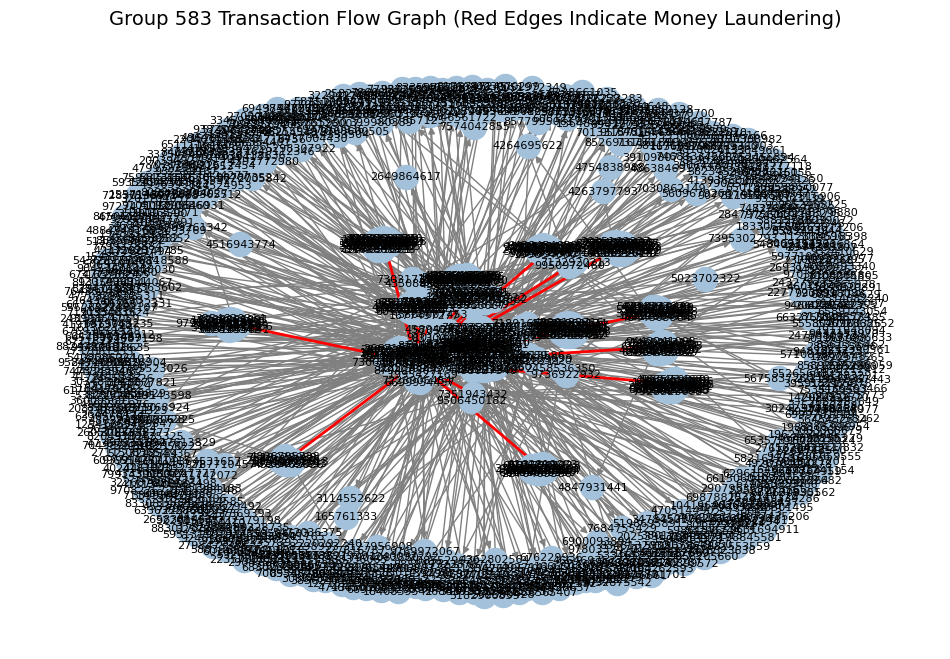

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# 建立 group 索引（如果還沒建立過）
# indexed_group_roots = list(groups.keys())  # ⬅️ 一定要有這行！

# 輸入 1~7 等群組編號（代表第幾個 group）
group_number = int(input("請輸入群組編號："))
group_root = indexed_group_roots[group_number - 1]
group_accounts = set(groups[group_root])

# 建立有向圖
G = nx.DiGraph()

# 篩選該群組內的交易邊
for row in df.iter_rows(named=True):
    sender = row["Sender_account"]
    receiver = row["Receiver_account"]
    laundering = int(row["Is_laundering"])
    if sender in group_accounts and receiver in group_accounts:
        G.add_edge(sender, receiver, laundering=laundering)

# 畫圖
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="#a3c1da")
nx.draw_networkx_labels(G, pos, font_size=8)

# 畫非洗錢邊（灰色）
nx.draw_networkx_edges(
    G, pos,
    edgelist=[(u, v) for u, v, d in G.edges(data=True) if d["laundering"] == 0],
    edge_color="gray", arrows=True
)

# 畫洗錢邊（紅色）
nx.draw_networkx_edges(
    G, pos,
    edgelist=[(u, v) for u, v, d in G.edges(data=True) if d["laundering"] == 1],
    edge_color="red", arrows=True, width=2
)

plt.title(f"Group {group_number} Transaction Flow Graph (Red Edges Indicate Money Laundering)", fontsize=14)
plt.axis("off")
plt.show()


In [9]:
# 建立 root 編號與對應 index 的 mapping（和圖示時一致）
indexed_group_roots = list(groups.keys())

# 建立群組洗錢筆數的計數 dict：{群組編號: 洗錢筆數}
laundering_count = {}

# 檢查每一筆交易是否在某個群組中且標記為洗錢
for row in df.iter_rows(named=True):
    if int(row["Is_laundering"]) == 1:
        sender = row["Sender_account"]
        receiver = row["Receiver_account"]

        # 找出 sender 所屬群組 root
        if sender in parent:
            root = find(sender)
            if root in indexed_group_roots:
                idx = indexed_group_roots.index(root) + 1  # 群組編號從 1 開始
                laundering_count[idx] = laundering_count.get(idx, 0) + 1

# 排序後輸出結果
sorted_groups = sorted(laundering_count.items(), key=lambda x: x[1], reverse=True)

print("📊 含洗錢交易的群組（依洗錢筆數排序）：")
for gid, count in sorted_groups:
    print(f"✅ 群組 {gid}：有 {count} 筆洗錢交易")

print(f"\n🔴 總共有 {len(laundering_count)} 個群組包含洗錢交易")


📊 含洗錢交易的群組（依洗錢筆數排序）：
✅ 群組 583：有 47 筆洗錢交易
✅ 群組 663：有 45 筆洗錢交易
✅ 群組 751：有 44 筆洗錢交易
✅ 群組 318：有 42 筆洗錢交易
✅ 群組 521：有 41 筆洗錢交易
✅ 群組 155：有 40 筆洗錢交易
✅ 群組 408：有 38 筆洗錢交易
✅ 群組 456：有 38 筆洗錢交易
✅ 群組 355：有 38 筆洗錢交易
✅ 群組 1319：有 37 筆洗錢交易
✅ 群組 15122：有 37 筆洗錢交易
✅ 群組 878：有 36 筆洗錢交易
✅ 群組 903：有 36 筆洗錢交易
✅ 群組 40：有 35 筆洗錢交易
✅ 群組 518：有 34 筆洗錢交易
✅ 群組 2278：有 34 筆洗錢交易
✅ 群組 809：有 34 筆洗錢交易
✅ 群組 364：有 34 筆洗錢交易
✅ 群組 533：有 33 筆洗錢交易
✅ 群組 789：有 32 筆洗錢交易
✅ 群組 417：有 32 筆洗錢交易
✅ 群組 7274：有 31 筆洗錢交易
✅ 群組 555：有 31 筆洗錢交易
✅ 群組 2838：有 31 筆洗錢交易
✅ 群組 5675：有 31 筆洗錢交易
✅ 群組 2717：有 30 筆洗錢交易
✅ 群組 1180：有 30 筆洗錢交易
✅ 群組 5979：有 29 筆洗錢交易
✅ 群組 278：有 29 筆洗錢交易
✅ 群組 661：有 28 筆洗錢交易
✅ 群組 1076：有 28 筆洗錢交易
✅ 群組 13008：有 28 筆洗錢交易
✅ 群組 14088：有 28 筆洗錢交易
✅ 群組 1355：有 27 筆洗錢交易
✅ 群組 717：有 27 筆洗錢交易
✅ 群組 1468：有 27 筆洗錢交易
✅ 群組 1533：有 27 筆洗錢交易
✅ 群組 629：有 26 筆洗錢交易
✅ 群組 12689：有 26 筆洗錢交易
✅ 群組 8535：有 26 筆洗錢交易
✅ 群組 8472：有 26 筆洗錢交易
✅ 群組 1234：有 26 筆洗錢交易
✅ 群組 12616：有 26 筆洗錢交易
✅ 群組 8048：有 25 筆洗錢交易
✅ 群組 8866：有 25 筆洗錢交易
✅ 群組 36：有 25 筆洗錢交易
✅ 群組 9916：有 25 筆洗錢交易
✅ 群組 2075：有 2